## 0. Imports

In [8]:
import requests
import json
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import display
import ipywidgets

In [2]:
# If True, always calls the API for new data. Otherwise saved data is used if available
refetch_data = False

In [3]:
# Paths
playlist_content_save_path = "./playlist_content_data.json"
album_content_save_path = "./album_content_data.json"

## 1. Get Access Token
Use the spotify developer credentials in the `credentials.json` file to generate an access token (valid for 1 hour).

In [10]:
def get_spotify_access_token():
    # Read the credentials from the JSON file
    with open("credentials.json", 'r') as file:
        credentials = json.load(file)
        client_id = credentials["client_id"]
        client_secret = credentials["client_secret"]
        
    # Get access token from spotify
    url = "https://accounts.spotify.com/api/token"
    headers = {"Content-Type": "application/x-www-form-urlencoded"}
    data = {"grant_type": "client_credentials", "client_id": client_id, "client_secret": client_secret}

    response = requests.post(url, headers=headers, data=data)
    
    if response.status_code == 200:
        return response.json()["access_token"]
    else:
        print(f"Access token request failed, Status Code: {response.status_code}")
        return None

In [11]:
access_token = get_spotify_access_token()

## 2. Get Playlist Content
Fetch complete playlist data from a playlist id

In [4]:
def get_playlist_content(playlist_id, save_to_file=True):
    url = "https://api.spotify.com/v1/playlists/" + playlist_id
    headers = {"Authorization": "Bearer " + access_token}
    
    base_response = requests.get(url, headers=headers)
    print(f"Requested: {url}, Status Code: {base_response.status_code}")
    
    if base_response.status_code == 200:
        base_response_json = base_response.json()
        next_url = base_response_json["tracks"]["next"]
    else:
        print("Failed to fetch playlist data")
        return None        
    
    while next_url is not None:
        response = requests.get(next_url, headers=headers)
        print(f"Requested: {next_url}, Status Code: {response.status_code}")
        
        if response.status_code == 200:
            additional_tracks = response.json()
            base_response_json["tracks"]["items"].extend(additional_tracks["items"])
            next_url = additional_tracks["next"]
        else:
            print("Failed to fetch playlist data")
            return None

    if save_to_file:
        with open(playlist_content_save_path, "w") as save_file:
            json.dump(base_response_json, save_file)

    return base_response_json

In [20]:
if refetch_data or not os.path.exists(playlist_content_save_path):
    playlist_json = get_playlist_content(playlist_id="4hnDUcviGrwCf46xa7vzfR")
else:
    with open(playlist_content_save_path, "r") as save_file:
        playlist_json = json.load(save_file)
        print("Loaded data from save file")

Loaded data from save file


In [21]:
print(f"Length of playlist: {len(playlist_json['tracks']['items'])}")

Length of playlist: 355


In [22]:
print("Last five songs in playlist:")
tracks = playlist_json["tracks"]["items"]

for track in tracks[-5:]:
    name = track["track"]["name"]
    artists = [artist["name"] for artist in track["track"]["artists"]]
    print(" -", name, artists)

Last five songs in playlist:
 - With Me ['Sum 41']
 - Your Sword Versus My Dagger ['Silverstein']
 - Our Song ['Silverstein']
 - The Foundations of Decay ['My Chemical Romance']
 - A Better Place ['Silverstein']


## 3. Get Album Data
The playlist api does not contain all datapoints on the tracks. Fetching the albums separately is necessary

In [23]:
def get_album_data(album_id):
    album_url = f"https://api.spotify.com/v1/albums/{album_id}"
    headers = {"Authorization": f"Bearer {access_token}"}
    response = requests.get(album_url, headers=headers)
    
    return response

In [24]:
def get_playlist_albums_data(playlist_json, save_to_file=True):
    album_ids = list(set(track["track"]["album"]["id"] for track in playlist_json["tracks"]["items"]))
    albums_data = {}
    
    for album_id in tqdm(album_ids):
        response = get_album_data(album_ids[0])
        if response.status_code == 200:
            albums_data[album_id] = response.json()
        else:
            print(f"Request failed for album {album_id}, Status Code: {response.status_code}")

    if save_to_file:
        with open(album_content_save_path, "w") as save_file:
            json.dump(albums_data, save_file)
        
    return albums_data

In [26]:
if refetch_data or not os.path.exists(album_content_save_path):
    albums_data = get_playlist_albums_data(playlist_json)
else:
    with open(album_content_save_path, "r") as save_file:
        albums_data = json.load(save_file)
        print("Loaded data from save file")

Loaded data from save file


In [27]:
albums_data["15XNBzVWARPMlu0sEbfBjJ"].keys()

dict_keys(['album_type', 'artists', 'available_markets', 'copyrights', 'external_ids', 'external_urls', 'genres', 'href', 'id', 'images', 'label', 'name', 'popularity', 'release_date', 'release_date_precision', 'total_tracks', 'tracks', 'type', 'uri'])

In [28]:
albums_data["15XNBzVWARPMlu0sEbfBjJ"]["name"]

'Hot Fuss'

## 4. Simple Analysis of Playlist

In [29]:
def analyse_playlist(playlist_json):
    explicit_track = {}
    popularity = {key: 0 for key in range(101)}  # Populate in advance to ensure sorted by popularity value
    artists = {}
    track_length = []
    
    for track in playlist_json["tracks"]["items"]:
        explicit_track[track["track"]["explicit"]] = explicit_track.get(track["track"]["explicit"], 0) + 1
        popularity[track["track"]["popularity"]] = popularity.get(track["track"]["popularity"], 0) + 1
        artists[track["track"]["artists"][0]["name"]] = artists.get(track["track"]["artists"][0]["name"], 0) + 1  # Main artist only currently
        track_length.append(track["track"]["duration_ms"] / 60000)  # Convert to mins   
        
    # Sort
    artists = dict(sorted(artists.items(), key=lambda item: item[1], reverse=True))
    
    return {"explicit_track": explicit_track, "popularity": popularity, "artists": artists, "track_lengths": track_length}

In [30]:
playlist_analysis_data = analyse_playlist(playlist_json)

### Analysis Plot

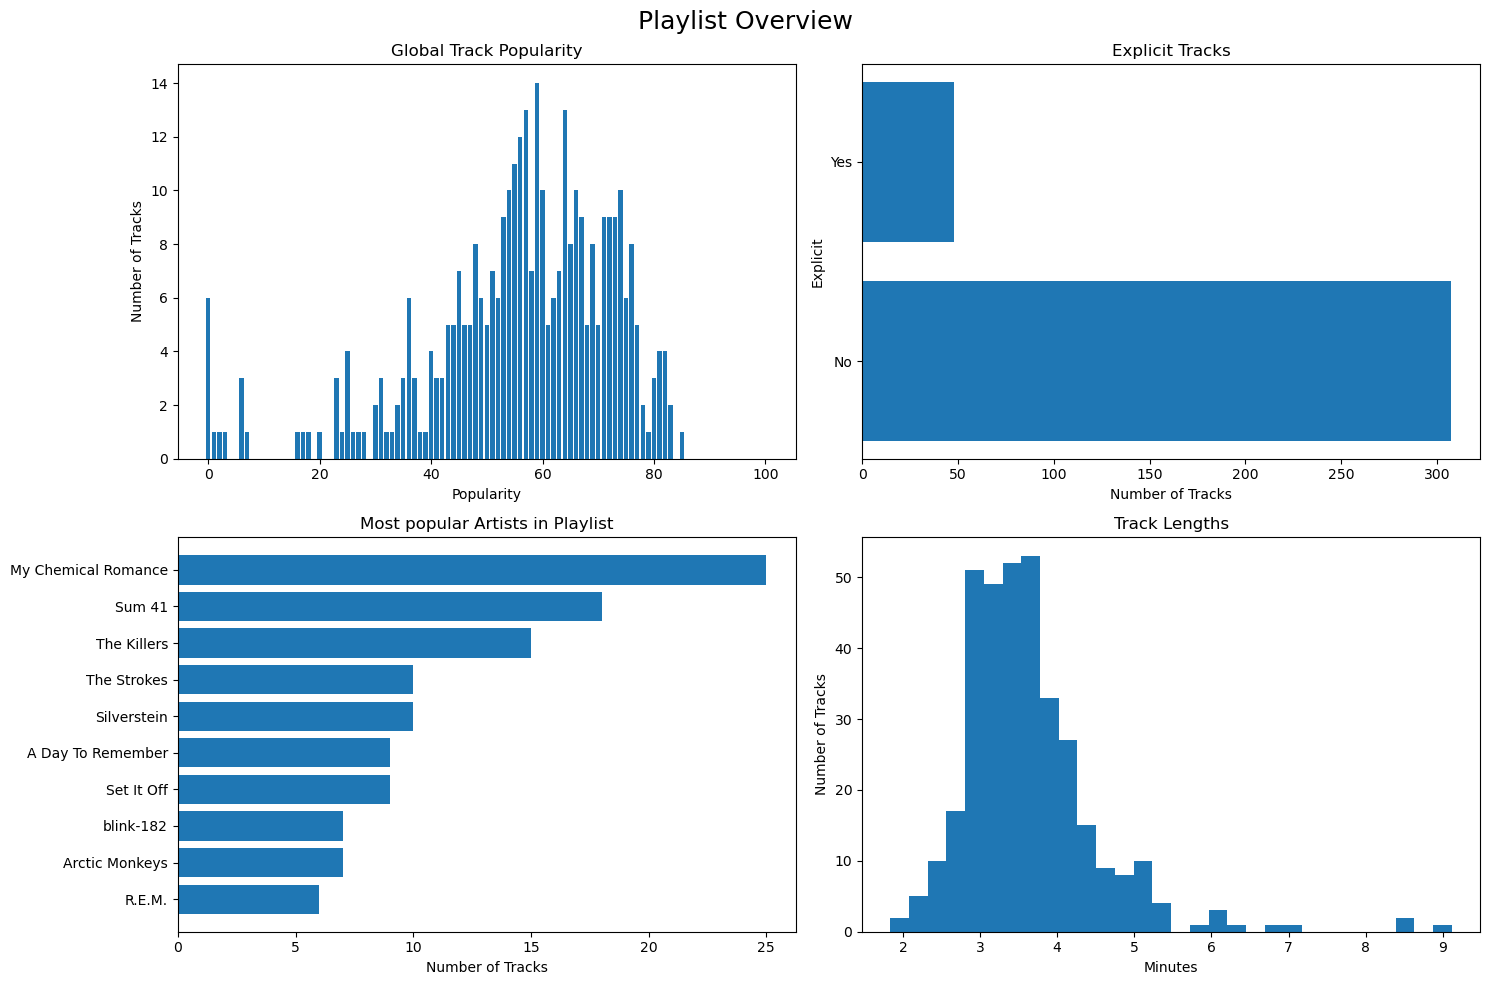

In [31]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1
axs[0, 0].bar(playlist_analysis_data["popularity"].keys(), playlist_analysis_data["popularity"].values())
axs[0, 0].set_ylabel('Number of Tracks')
axs[0, 0].set_xlabel('Popularity')
axs[0, 0].set_title('Global Track Popularity')

# Plot 2
axs[0, 1].barh(["No", "Yes"], playlist_analysis_data["explicit_track"].values())
axs[0, 1].set_ylabel('Explicit')
axs[0, 1].set_xlabel('Number of Tracks')
axs[0, 1].set_title('Explicit Tracks')

# Plot 3
axs[1, 0].barh(list(playlist_analysis_data["artists"].keys())[:10][::-1], 
               list(playlist_analysis_data["artists"].values())[:10][::-1])
axs[1, 0].set_xlabel('Number of Tracks')
axs[1, 0].set_title('Most popular Artists in Playlist')


# Plot 4
axs[1, 1].hist(playlist_analysis_data["track_lengths"], bins=30)
axs[1, 1].set_title('Track Lengths')
axs[1, 1].set_xlabel('Minutes')
axs[1, 1].set_ylabel('Number of Tracks')

plt.suptitle("Playlist Overview", size=18)
plt.tight_layout()
plt.show()

In [33]:
checkboxes = [ipywidgets.Checkbox(value=False if num < 2 else True, description=band) for band, num in playlist_analysis_data["artists"].items()]
grid_layout = ipywidgets.GridBox(children=checkboxes, layout=ipywidgets.Layout(
    width='100%',
    height='auto',
    border='1px solid black',
    display='flex',
    flex_flow='row wrap',
    justify_content='space-around',
    padding='0 0px'
))

display(grid_layout)

GridBox(children=(Checkbox(value=True, description='My Chemical Romance'), Checkbox(value=True, description='S…

In [34]:
def get_selected_artists():
    return [checkbox.description for checkbox in checkboxes if checkbox.value]

In [48]:
selected_artists = get_selected_artists()

In [ ]:
def get_artist_albums()

In [78]:
url = 'https://musicbrainz.org/ws/2/artist/f2eef649-a6d5-4114-afba-e50ab26254d2?inc=release-groups&fmt=json'

params = {
    'mbid': 'f2eef649-a6d5-4114-afba-e50ab26254d2',
    'inc': 'releases',  # Include releases in the response
    'fmt': "json"       # Limit the number of releases returned
}

headers = {
    'Accept': 'application/json'
}

artist_mbid = 'f2eef649-a6d5-4114-afba-e50ab26254d2'
browse_url = f'https://musicbrainz.org/ws/2/release-group?mbid={artist_mbid}&inc=releases&fmt=json'

# Perform the POST request
# response = requests.get(url, params=params, headers=headers)
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    print('Query submitted successfully')
else:
    print('Failed to submit query')

Query submitted successfully


In [79]:
response.json()

{'life-span': {'end': None, 'ended': False, 'begin': '1996'},
 'id': 'f2eef649-a6d5-4114-afba-e50ab26254d2',
 'name': 'Sum 41',
 'sort-name': 'Sum 41',
 'isnis': ['0000000122539531'],
 'disambiguation': '',
 'gender-id': None,
 'end-area': None,
 'begin-area': {'disambiguation': '',
  'type-id': None,
  'type': None,
  'sort-name': 'Ajax',
  'name': 'Ajax',
  'id': '595619e1-3cd4-467c-b79e-75ff9ed72d9b'},
 'release-groups': [{'title': 'All Killer No Filler',
   'disambiguation': '',
   'primary-type': 'Album',
   'first-release-date': '2001-05-08',
   'secondary-type-ids': [],
   'id': 'dd2c168f-41a6-37f5-a727-6e188bf22c6e',
   'primary-type-id': 'f529b476-6e62-324f-b0aa-1f3e33d313fc',
   'secondary-types': []},
  {'primary-type': 'Album',
   'disambiguation': '',
   'title': 'Does This Look Infected?',
   'secondary-types': [],
   'primary-type-id': 'f529b476-6e62-324f-b0aa-1f3e33d313fc',
   'id': '3ebc1782-e140-3a1a-971e-17826ddf462d',
   'secondary-type-ids': [],
   'first-release-d